## Preprocess widefield calcium imaging data using Spark
This notebook demonstrates how to read binary raw data files stored on UZH Swift object storage into a Spark RDD, convert it into a Numpy array and perform preprocessing to generate a DFF array. Both the raw data and DFF arrays are stored as output HDF5 files on the Swift object storage. **It's setup to test different parameters (e.g. Spark number of cores) in a loop.** For details and better documentation see the notebook Widefield_Preproc_Spark_Swift.

### Imports

In [1]:
# Import Python modules
import os, sys
import numpy as np
from matplotlib import pylab as plt
from __future__ import print_function
import getpass
import h5py
import tempfile
import shutil
import time
import datetime

%matplotlib inline

# the notebook backend: 'local' or 'openstack'
nbBackend = 'local'

# add folder 'utils' to the Python path
# this folder contains custom written code that is required for data import and analysis
utils_dir = os.path.join(os.getcwd(), 'utils')
sys.path.append(utils_dir)

# Import custom-written modules
import SwiftStorageUtils
import WidefieldDataUtils as wf
import PickleUtils as pick
import CalciumAnalysisUtils as calciumTools
import parseDCIMGheader as parseDCIMGheader
from SwiftStorageUtils import saveAsH5
from SwiftStorageUtils import deleteExistingFolder

### File paths and directories

In [2]:
# start of name for matching files
filename_start = '20152310' # all files with names starting like this will be processed

# swift file system
swift_container = 'ariel' # specify name of container in Swift (do not use _ etc. in container names!)
swift_provider = 'SparkTest' # in general, this should not change

# derive the Swift base URI
swift_basename = "swift://" + swift_container + "." + swift_provider + "/"

In [3]:
# OpenStack credentials for accessing Swift storage
os_username = 'hluetc'
os_tenant_name = 'helmchen.hifo.uzh'
os_auth_url = 'https://cloud.s3it.uzh.ch:5000/v2.0'
# provide OS password
os_password = getpass.getpass()

········


In [4]:
# put all these parameters in a dictionary, so that we can pass them conveniently to functions
file_params = dict()
file_params['filename_start'] = filename_start
file_params['swift_container'] = swift_container
file_params['swift_provider'] = swift_provider
file_params['swift_basename'] = swift_basename
file_params['os_username'] = os_username
file_params['os_tenant_name'] = os_tenant_name
file_params['os_auth_url'] = os_auth_url
file_params['os_password'] = os_password

### Experiment & analysis parameters

In [5]:
# image dimensions for analysis (aspect ratio MUST be preserved)
dims_analysis = (256,256) # use None to skip resizing

# sampling rate and trial times
sample_rate = 20.0 # Hz
t_stim = -1.9 # stimulus cue (auditory)
t_textIn = 0 # texture in (i.e. stimulus onset)
t_textOut = 2 # texture starting to move out (stimulus offset)
t_response = 4.9 # response cue for licking (auditory)
t_base = -2 # baseline end (for F0 calculation)

# Analysis parameters
bg_smooth = 30 # SD of Gaussian smoothing kernel for background estimation (in pixel) 

seg_cutoff = 0.0002 # Segmentation threshold; larger value = bigger mask; 
# smaller value = smaller mask (i.e. more pixels ignored); suggested = 0.0002

### Define required functions
Note that this approach only works in the notebook because variables are globally defined. If this code is ported to a standalone Python app, all variables need to be passed explicitely to the functions.

In [6]:
def startSparkContext(spark_instances=6):
    from setupSpark import initSpark
    
    spark_instances = spark_instances # the number of workers to be used
    executor_cores = 2 # the number of cores to be used on each worker
    executor_memory = '6G' # the amount of memory to be used on each worker
    max_cores = spark_instances*executor_cores # the max. number of cores Spark is allowed to use overall

    # returns the SparkContext object 'sc' which tells Spark how to access the cluster
    sc = initSpark(nbBackend, spark_instances=spark_instances, executor_cores=executor_cores, \
                   max_cores=max_cores, executor_memory=executor_memory)
    
    # provide OpenStack credentials to the Spark Hadoop configuration
    sc._jsc.hadoopConfiguration().set('fs.swift.service.SparkTest.username', os_username)
    sc._jsc.hadoopConfiguration().set('fs.swift.service.SparkTest.tenant', os_tenant_name)
    sc._jsc.hadoopConfiguration().set('fs.swift.service.SparkTest.password', os_password)
    
    # add Python files in 'utils' folder to the SparkContext 
    # this is required so that all files are available on all the cluster workers
    for filename in os.listdir(utils_dir):
        if filename.endswith('.py'):
            sc.addPyFile(os.path.join(utils_dir, filename))
            
    return sc

In [7]:
def convertDCAMtoMov(byte_stream):
    """
    Convert raw DCAM byte-stream to movie. 
    
    Note that parameters (e.g. dims_analysis) are provided as global variables in the notebook.
    Image dimensions are obtained by parsing the file header.
    """
    # parse the header and get image dimensions
    hdr = parseDCIMGheader.main(byte_stream)
    dims = [hdr['xsize'], hdr['ysize'], hdr['nframes']]
    
    byte_stream = byte_stream[232:] # 232 bytes is the file header
    A = np.fromstring(byte_stream, dtype=np.uint16)
    A = A[:dims[0]*dims[1]*dims[2]] # remove data points at the end
    
    # re-arrange data into the correct shape
    mov = np.fliplr(A.reshape([dims[0], dims[1], dims[2]], order='F'))
    # hack to remove strange pixels with very high intensity
    mov[np.where(mov > 60000)] = 0
    
    # resize to analysis dimensions
    mov = wf.resizeMovie(mov, resolution=dims_analysis, interp='bilinear')
    
    return mov

In [8]:
def preprocMovie(mov, bg_smooth=bg_smooth, seg_cutoff=seg_cutoff):
    """
    Perform preprocessing steps for a movie. 
    """
    
    # estimate background signal intensity
    print('Estimating background', end="")
    bg_estimate = wf.estimateBackground(mov[:,:,0], bg_smooth)
    print(' - Done (%1.2f)' % bg_estimate)
    
    # subtract the background (set negative to 0)
    mov = mov - bg_estimate
    mov[mov<0] = 0
    
    # segment out the background (set to np.nan)
    print('Segmenting background', end="")
    mov = wf.segmentBackground(mov, seg_cutoff, plot=False)
    print(' - Done')
    
    # baseline normalization (Dff)
    print('Calculating Dff', end="")
    dff = calciumTools.calculateDff(mov , f0_frames)
    print(' - Done')
    
    return dff

In [9]:
def getFileNameFromKey(key):
    """
    Return the file name from the RDD key (i.e. split of the swift URL)
    """
    path, name = os.path.split(key)
    return name

In [10]:
def setupRDDs(sc, file_params):
    file_rdd = sc.binaryFiles(file_params['swift_basename'])
    file_rdd = file_rdd.filter(lambda (k,v): file_params['filename_start'] in k)
    # convert byte-stream to movie
    mov_rdd = file_rdd.map(lambda (k,v): (k, convertDCAMtoMov(v)))
    return (file_rdd, mov_rdd)

### Main loop to sweep over parameter space

In [11]:
# test execution time as a function of number of cores
# max_cores_list = range(48,6,-4)
max_instance_list = [1]

# Set the names for the output folders
output_folder_mov = 'mov_out'
output_folder_dff = 'dff_out'

t_mov = []
t_dff = []
for i_instances in max_instance_list:
    sc = startSparkContext(spark_instances=i_instances)
    file_rdd, mov_rdd = setupRDDs(sc, file_params)
    if len(t_mov) == 0:
        # things that only need to be done once
        nTrials = file_rdd.count()
        # get first movie (return key-value tuple)
        mov1 = mov_rdd.first()
        path, file_id = os.path.split(mov1[0])
        dat = mov1[1]
        timepoints = dat.shape[2]
        t = (np.array(range(timepoints)) / sample_rate) - 3.0
        # Frames for F0 calculation
        f0_frames = t<t_base # F0 as time before baseline
        f0_frames[:] = False
        f0_frames[9:12] = True # F0 as certain specified frames
    
    # apply transformation to the RDD
    dff_rdd = mov_rdd.map(lambda (k,v): (k, preprocMovie(v)))
    
    deleteExistingFolder(swift_container, output_folder_mov, file_params, confirm=False)
    deleteExistingFolder(swift_container, output_folder_dff, file_params, confirm=False)
    
    t0 = time.time()
    # Save the image data as HDF5 on Swift storage. 
    mov_rdd.foreach(lambda (k,v): (k, saveAsH5(v, getFileNameFromKey(k), 'mov', output_folder_mov, file_params)))
    t_mov.append(time.time() - t0)
    
    print('Instances: %1.0f' % (i_instances))
    print('t mov: %1.2f s' % (t_mov[-1]))
    
    t0 = time.time()
    # Save the dFF data as HDF5 on Swift storage. 
    dff_rdd.foreach(lambda (k,v): (k, saveAsH5(v, getFileNameFromKey(k), 'dff', output_folder_dff, file_params)))
    t_dff.append(time.time() - t0)
    
    print('t dff: %1.2f s' % (t_dff[-1]))
    
    sc.stop()

No matching objects.
Instances: 1
t mov: 555.45 s
t dff: 664.74 s


### Plot and save results

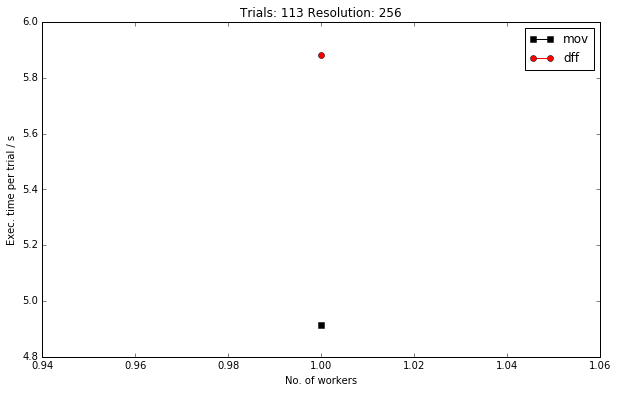

In [12]:
now = datetime.datetime.now()
time_str = now.strftime('%Y%m%d-%H%M%S')
filename = 'Line_TimePerTrial_vs_nWorker_%1.0f_%s.eps' % (dims_analysis[0], time_str)
t_mov_perTrial = [yy/nTrials for yy in t_mov]
t_dff_perTrial = [yy/nTrials for yy in t_dff]
plt.figure(figsize=(10,6))
plt.plot(max_instance_list, t_mov_perTrial, 'ks-')
plt.plot(max_instance_list, t_dff_perTrial, 'ro-')
plt.legend(['mov', 'dff'])
plt.xlabel('No. of workers')
plt.ylabel('Exec. time per trial / s')
plt.title('Trials: %1.0f Resolution: %1.0f' % (nTrials, dims_analysis[0]))
plt.savefig(filename)

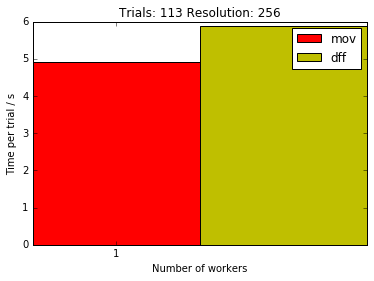

In [13]:
filename = 'Bar_TimePerTrial_vs_nWorker_%1.0f_%s.eps' % (dims_analysis[0], time_str)
N = len(max_instance_list)
width = 0.35
fig, ax = plt.subplots()
ind = np.arange(N)  # the x locations for the groups
rects1 = ax.bar(ind, t_mov_perTrial, width, color='r')
rects2 = ax.bar(ind + width, t_dff_perTrial, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Time per trial / s')
ax.set_xlabel('Number of workers')
ax.set_title('Trials: %1.0f Resolution: %1.0f' % (nTrials, dims_analysis[0]))
xticks = [yy + width for yy in max_instance_list]
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(max_instance_list)
plt.legend(('mov', 'dff'), loc='best')
plt.savefig(filename)

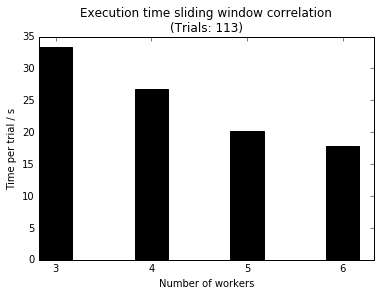

In [10]:
worker_no = [3, 4, 5, 6]
exec_time = [33.34, 26.71, 20.25, 17.78]

now = datetime.datetime.now()
time_str = now.strftime('%Y%m%d-%H%M%S')
path = '/Users/Henry/Data/ETH_SIS/eSCT_Project/eSCT_Neuro/2017-01_NeuroSpark_Poster/PerformanceTests'
filename = 'Bar_TimePerTrial_vs_nWorker_Corr_%s.eps' % (time_str)

N = len(worker_no)
width = 0.35
fig, ax = plt.subplots()
ind = np.arange(N)  # the x locations for the groups
rects1 = ax.bar(ind, exec_time, width, color='k')

# add some text for labels, title and axes ticks
ax.set_ylabel('Time per trial / s')
ax.set_xlabel('Number of workers')
ax.set_title('Execution time sliding window correlation\n(Trials: %1.0f)' % (113))
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(worker_no)
plt.savefig(path + os.path.sep + filename)